# Prioritizing targets with TSM and expected total exposure time
This adaptation of Nicholas' prioritization code is essentially the same as found in the Priority-Tools-Tutorial notebook, but there is a slight change to the prioritization ranking, motivated by a need to integrate the SC3-Atmospheres prioritization scheme with Ashley Chontos' algorithm and incorporate suggestions from Ian Crossfield. **Instead of sorting the targets in each bin by the TSM value (see [Kempton et al. 2018](https://arxiv.org/abs/1805.03671)), and then sorting the top three in TSM by their $V$ magnitude, we sort the bins by the ratio of their TSM and the total estimated exposure time needed on HIRES to achieve a 5-$\sigma$ mass, $t_\mathrm{HIRES}$**:

\begin{align}
X & \equiv \frac{\mathrm{TSM}}{t_\mathrm{HIRES}}.
\end{align}

$t_\mathrm{HIRES}$ is a function of the target's $V$ magnitude, a **chosen** number of exposure meter counts (in thousands), $n_\mathrm{counts}$, and the planet's radius, $R_\mathrm{pl}$ (which is used in the empirical mass-radius relation from [Chen & Kipping 2017](https://arxiv.org/abs/1603.08614)):

\begin{align}
t_\mathrm{HIRES} & = t_\mathrm{ob}(V, n_\mathrm{counts}) \times N_\mathrm{obs}(n_\mathrm{counts}, R_\mathrm{pl}) \\
& = t_\mathrm{ob}(V, n_\mathrm{counts}) \times \Big(\frac{5 \cdot \sigma(n_\mathrm{counts})}{K(R_\mathrm{pl})}\Big)^2,
\end{align}
where $t_\mathrm{ob}$ is the exposure time (in seconds) of a single observation, $N_\mathrm{obs}$ is the number of observations needed to achieve the 5-$\sigma$ mass measurement, $\sigma$ is the typical velocity uncertainty (in m/s) on a single RV measurement, and $K$ is the estimated semi-amplitude of the planetary radial velocity signal (in m/s). Functional dependencies are noted in parentheses following dependent variables.

The equation for $N_\mathrm{obs}$ is taken from the equation on page 19 of [Plavchan et al. 2015](https://arxiv.org/abs/1503.01770). $\sigma$ is **roughly** converted from exposure meter counts to velocity precision using https://caltech-ipac.github.io/hiresprv/performance.html.

A larger $X$ value $\rightarrow$ higher priority.

*An example of why the two ranking methods may assign different priorities could be...* Suppose TOI-A and TOI-B have the same TSM value, but TOI-B is brighter in $V$ than TOI-A. In the previous prioritization scheme, TOI-B would be given a higher priority than TOI-A. Suppose the expected K-amplitude of the planetary signal is larger for TOI-A, though, because e.g. the planet is expected to be more massive based on the Chen & Kipping mass-radius relation. This **might** give TOI-A a smaller $t_\mathrm{HIRES}$ value making, it a higher priority than TOI-B in this ranking scheme.

In [3]:
# Load necessary packages and tools

# System
import os
import glob

# Data/analysis
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100 # See all of the columns when DFs are displayed

# Util functions
from priority_tools import * # Implementation details and comments can be found in this file

# Plotting (with fancy font/backend output)
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # For high quality figures

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Do some initial data loading, cleaning

In [4]:
def get_newest_csv(folder_path):
    '''
    Get the filename of csv file in folder_path that is the most recent.
    
    Taken from: https://stackoverflow.com/questions/39327032/how-to-get-the-latest-file-in-a-folder-using-python
    '''
    folder_path += '*.csv'
    list_of_files = glob.glob(folder_path) # * means all if need specific format then *.csv
    return max(list_of_files, key=os.path.getctime)

toi_path = get_newest_csv('data/toi/')
tic_path = get_newest_csv('data/exofop/')

# Check to make sure these are the files that you want to use
print('TOI+ list file used: \t {}'.format(toi_path))
print('TIC ExoFOP file used: \t {}'.format(tic_path))

TOI+ list file used: 	 data/toi/toi+-2020-03-23.csv
TIC ExoFOP file used: 	 data/exofop/TIC_star_info_2020-03-23.csv


In [6]:
# Code in this cell taken from Nicholas

# Generate the key names for all the TOI+ columns we need.
# See column_key_names.txt for what these are
rp_key,ms_key,pp_key,Ts_key,ars_key,Jmag_key,\
    Vmag_key,rs_key,dec_key,Fp_key,mp_key,\
    mp_units,id_key = tess_colnames()

# Load the TOI+ list
toiplus = pd.read_csv(toi_path, delimiter=',',header=4)

# Load the TIC star info
# Note: This pd.read_csv() call is being finicky for some reason... - Joey, 03/23/20
TIC_info = pd.read_csv(tic_path, delimiter=',', comment='#', header=1, usecols=[0,1,2,3,4,5,6])

# Run the data cleaning function 
tess = clean_tess_data(toiplus, TIC_info, include_qlp=False)

# Load the known planets (and Kepler PCs) table, and merge it
kps = pd.read_csv(r'data/kp-k14_pc-v14.csv')
df = tess.append(kps[np.logical_and(kps['K_amp'] > 1.5, kps['TSM'] > 10)],sort=False) 
    # The K_amp cut wasn't made in the data itself, but is 
    # necessary to cut some of those not-real long-period
    # KOIs as well as known planets for which we can't get masses
print("This dataframe has {} rows.".format(len(df)))

This dataframe has 1225 rows.


## Calculate $t_\mathrm{HIRES}$ for each entry in the dataframe

In [7]:
# Setting n_counts by hand to 250k for every target right now, but this should be changed in the future,
# since targets can get away with lower exposure meter counts based on e.g. their V mag. 
# - Joey, 03/22/20

# Maybe it's alright to leave it at 250k, since it's just a relative estimate of the exposure time i.e.
# "This is what the exposure time would be *if* we had 250k on the counts for every observation."
n_counts = 250
df['t_HIRES'] = t_HIRES(df['V mag'], n_counts, df['K_amp'])
df['X'] = df['TSM']/df['t_HIRES']

In [8]:
# Get a sense of what information this dataframe has
df.head()

,Source Pipeline,TIC,Full TOI ID,TIC Right Ascension,TIC Declination,TMag Value,TMag Uncertainty,Orbital Epoch Value,Orbital Epoch Error,Orbital Period Value,Orbital Period Error,Transit Duration Value,Transit Duration Error,Transit Depth Value,Transit Depth Error,Sectors,Public Comment,Surface Gravity Value,Surface Gravity Uncertainty,Signal ID,Star Radius Value,Star Radius Error,Planet Radius Value,Planet Radius Error,Planet Equilibrium Temperature (K) Value,Effective Temperature Value,Effective Temperature Uncertainty,Effective Stellar Flux Value,Signal-to-noise,Centroid Offset,Alerted,Updated,Stellar Mass,pl_masses,Ars,K_amp,Target,RA,Dec,V mag,J mag,H mag,K mag,TSM,Unnamed: 0,t_HIRES,X
0,spoc,236887394.0,1465.01,303.381740,65.162081,11.84780,0.006100,1766.006690,0.000222,1.420035,0.000025,1.616557,0.018567,24055.374561,186.915340,17,Qatar-1 b,4.57248,0.082846,1.0,0.768108,0.045256,12.392370,0.739193,1251.948474,4910.0,108.354,580.586351,136.635350,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.803438,103.637487,6.436608,68.343847,236887394.0,303.381870,65.162331,12.692,10.999,10.527,10.409,309.198571,NaN,31.033581,9.963355
1,spoc,427654774.0,1474.01,349.287339,70.190021,14.14310,0.007508,1765.042474,0.003388,5.222621,0.001436,4.693629,0.613360,15867.992018,2007.716000,17 18,3-sigma centroid offset towards another star.,4.95337,0.008643,1.0,0.275946,0.008483,3.721602,0.381201,329.650849,3453.0,157.000,2.790858,8.069622,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.249256,13.408967,28.898774,12.500258,427654774.0,349.289072,70.190576,16.502,12.710,12.171,11.928,84.255469,NaN,31002.221477,0.002718
2,spoc,237086564.0,1466.01,307.395886,61.550433,11.02780,0.006000,1766.255274,0.002566,1.871529,0.000393,1.643889,0.385031,1110.419780,106.224106,17,NaN,4.50790,0.110712,1.0,0.749646,0.071322,2.491658,2.504803,997.456843,4201.0,125.587,233.936214,10.331200,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.659539,6.779299,7.423079,4.650963,237086564.0,307.396532,61.550725,12.189,9.957,9.341,9.196,56.896330,NaN,4216.430343,0.013494
3,spoc,240968774.0,1467.01,19.113929,49.233780,10.59770,0.007301,1766.983728,0.002812,5.973384,0.001413,1.605698,0.753235,1373.411277,166.743070,17,NaN,4.74552,0.007707,1.0,0.490737,0.014515,1.827003,2.407974,525.913556,3834.0,157.000,18.079169,8.569228,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,0.488479,4.000472,22.240393,2.277148,240968774.0,19.114644,49.233138,12.293,9.380,8.791,8.568,61.002188,NaN,19357.453706,0.003151
4,spoc,431514478.0,1475.01,357.001182,49.790535,8.77994,0.006100,1767.618296,0.001783,8.495351,0.001270,0.906055,0.487170,718.486945,96.261400,17,Significant scattered light; only two transits...,4.29876,0.063938,1.0,1.880160,0.050161,5.296170,5.259954,1813.345207,10012.0,185.641,2555.306247,8.222785,NaN,2019-12-05 16:42:06+0000,2019-12-05 16:42:06+0000,2.563170,24.428101,12.756976,4.094757,431514478.0,357.001275,49.790533,8.790,8.695,8.708,8.687,71.521441,NaN,237.670059,0.300927


## Group all of the targets by bins in planet radius, insolation flux, and stellar effective temperature, and rank them according to the two different methods

In [9]:
# Code in this cell is adapted from code written by Nicholas

# Defining the bins:
# Log-uniform in radius and Fp, uniform in Teff. Right now, 
# you need 6 bin edges for radius and Fp and 4 for Teff; 
# we can change that by editing the "labels" in binning_function
rad_bins = 10**(np.linspace(0,1,6)) 
rad_bins[-1] = 11.2 #want to include up to Jupiter radius 
fpl_bins = 10**(np.linspace(-1,4,6))
tef_bins = np.array([2500,3900,5200,6500])
bins = [rad_bins, fpl_bins, tef_bins]

# The two different ranking methods:
# Sort things by TSM and then sort the top three in TSM by their Vmag
binned_TSM_Vmag_df = binning_function(df, bins)

# Sort things by the ratio of TSM and the total exposure time needed to get a 5-sigma mass
binned_X_df = binning_function_X(df, bins)

In [10]:
binned_X_df.loc[(3,3,3)]

Source Pipeline          TIC  \
radius_bin insol_bin st_Teff_bin                                
3          3         3                      spoc  269701147.0   
                     3                      spoc  453211454.0   
                     3                      spoc   33692729.0   
                     3                      spoc  377064495.0   
                     3                      spoc  269701147.0   
                     3                       NaN          NaN   
                     3                      spoc  232540264.0   
                     3                      spoc  268334473.0   
                     3                      spoc   71431780.0   
                     3                       NaN          NaN   
                     3                      spoc  377064495.0   
                     3                      spoc  153949511.0   
                     3                      spoc   49687222.0   
                     3                       NaN          NaN   
                     3                      spoc  224297258.0   
                     3                      spoc  264979636.0   
                     3                      spoc  232976128.0   
                     3                      spoc  229944666.0   
                     3                      spoc  435680451.0   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   
                     3                       NaN          NaN   

  

## Let's see if any of the prioritizations have actually changed between the two methods

In [11]:
# Cut down on some of the extraneous columns
useful_cols = ['Full TOI ID', rp_key, pp_key, Ts_key, Fp_key, 
               'Planet Equilibrium Temperature (K) Value', 'V mag','K_amp', 'TSM', 't_HIRES', 'X']
compare_df = pd.DataFrame()
compare_df[useful_cols] = binned_TSM_Vmag_df[useful_cols]
compare_df['TSM_Vmag_priority'] = binned_TSM_Vmag_df['priority']
compare_df = compare_df.merge(binned_X_df[useful_cols + ['priority']], on=useful_cols, left_index=True)
compare_df = compare_df.rename(columns={'priority':'X_priority'})

# Look at the rows where the two methods give different priority rankings
compare_diff_df = compare_df[compare_df['TSM_Vmag_priority'] != compare_df['X_priority']]

In [12]:
# Let's take a look
compare_diff_df

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                      
1          2         1               L 98-59 d             1.570000   
                     1                 1680.01             1.532034   
                     1            LTT 1445 A b             1.380000   
                     1                  455.01             1.368307   
           3         1                 1746.01             1.562508   
...                                        ...                  ...   
5          4         3               WASP-32 b            10.761000   
           5         3                  390.01             8.656736   
                     3                  485.01             8.411166   
                     3                 1254.01             7.875786   
                     3             HD 149026 b             8.295000   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
1          2         1                        7.450860   
                     1                        4.802445   
                     1                        5.358820   
                     1                        5.358807   
           3         1                        2.525267   
...                                                ...   
5          4         3                        2.718660   
           5         3                        1.470258   
                     3                        1.264563   
                     3                        1.018005   
                     3                        2.875890   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
1          2         1                                3367.00   
                     1                                3231.00   
                     1                                3337.00   
                     1                                3562.00   
           3         1                                3340.00   
...                                                       ...   
5          4         3                                6140.00   
           5         3                                6321.46   
                     3                                6084.00   
                     3                                5451.00   
                     3                                6179.00   

                                  Effective Stellar Flux Value  \
radius_bin insol_bin st_Teff_bin                                 
1          2         1                                4.333919   
                     1                                4.451358   
                     1                                5.952523   
                     1                                7.379879   
           3         1                               26.102671   
...                                                        ...   
5          4         3                              984.299245   
           5         3                             3333.408567   
                     3                             1027.020000   
                     3                             2488.221784   
                     3                             1311.969484   

                                  Planet Equilibrium Temperature (K) Value  \
radius_bin insol_bin st_Teff_bin                                             
1          2         1                                                 NaN   
                     1                                          370.461326   
                     1                                                 NaN   
                     1                                          420.370338   
           3         1                                          576.488948   
...                                                                    ...   
5          4         3     

### Let's take a look at targets that were unranked when sorting by TSM and Vmag, but are ranked now
We see that this metric favors a target if one of three metrics is very favorable: 1. TSM, 2. V mag, 3. K-amplitude.

In [13]:
compare_diff_df[compare_diff_df['TSM_Vmag_priority'] == 0]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                      
1          2         1                  455.01             1.368307   
           3         1                 1468.02             1.452351   
2          2         1               TOI 270 c             2.420000   
                     1               TOI 270 d             2.130000   
                     1                 1468.01             2.333273   
           3         1                 1695.01             2.085673   
                     1                 1238.01             2.288668   
                     2            HIP 116454 b             2.466000   
           4         1                 1285.01             1.866263   
                     2              HD 15337 b             1.640000   
           5         3             HD 213885 b             1.745000   
3          3         1                  620.01             2.729669   
                     2                  461.01             2.565840   
                     2                 1255.01             2.702780   
           4         3                 1736.01             3.702256   
4          2         3               K08217.01             5.020000   
           3         2                 1424.01             4.012561   
                     3             Kepler-63 b             6.110000   
           4         2              WASP-156 b             5.717000   
           5         3               K00272.01             4.520000   
5          2         3               K01411.01             7.820000   
           3         1                  519.01             9.497154   
                     2               HATS-22 b            10.682000   
                     3               WASP-84 b            10.559000   
                     3              WASP-130 b             9.976000   
           4         2               HAT-P-3 b            10.536000   
                     2               WASP-43 b            10.424000   
                     2              HAT-P-20 b             9.718000   
                     3               WASP-56 b            10.536000   
                     3               WASP-32 b            10.761000   
           5         3             HD 149026 b             8.295000   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
1          2         1                        5.358807   
           3         1                        1.880305   
2          2         1                        5.660172   
                     1                       11.380140   
                     1                       15.531925   
           3         1                        3.131463   
                     1                        3.293706   
                     2                        9.120500   
           4         1                        1.228439   
                     2                        4.756150   
           5         3                        1.008035   
3          3         1                        5.098373   
                     2                       14.490034   
                     2                       10.288882   
           4         3                        7.074152   
4          2         3                      277.251180   
           3         2                        4.897647   
                     3                        9.434151   
           4         2                        3.836169   
           5         3                        1.281328   
5          2         3                      305.076247   
           3         1                        1.265223   
                     2                        4.722812   
                     3                        8.523487   
                     3                       11.550980   
           4         2                        2.899700   
                     2                        0.813475   
         

### On the other hand, what targets were ranked by the original scheme, but get dropped by this one?

In [14]:
compare_diff_df[compare_diff_df['X_priority'] == 0]

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                           
1          2         1                    L 98-59 d             1.570000   
           3         1                      1746.01             1.562508   
2          2         1                       736.01             2.019085   
                     1                  LP 791-18 c             2.310000   
                     1                      1276.01             2.337752   
           3         1                       654.01             1.908260   
                     1                      K2-28 b             2.320000   
                     2                    GJ 9827 d             2.022000   
           4         1                      1289.01             2.201489   
                     2                      1416.01             1.659544   
           5         3                       638.01             1.940277   
3          3         1                       543.01             3.747202   
                     2                      1201.01             3.038206   
                     2                      K2-36 c             3.200000   
           4         3                      1136.02             3.002270   
4          2         3                 Kepler-453 b             6.204000   
           3         2                   HAT-P-11 b             4.360000   
                     3                      1449.01             4.756218   
           4         2                      1694.01             5.480027   
           5         3            EPIC 206036749.01             4.600000   
5          2         3                Kepler-1513 b             8.460000   
           3         1                       529.01             6.982290   
                     2                   HAT-P-18 b            11.153000   
                     3                      K2-24 c             7.500000   
                     3                      1775.01             8.074810   
           4         2                   HAT-P-12 b            10.749000   
                     2                    K07415.01            10.970000   
                     2                   HAT-P-26 b             7.062000   
                     3                   WASP-166 b             7.062000   
                     3                      1273.01            11.109674   
           5         3                      1254.01             7.875786   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
1          2         1                        7.450860   
           3         1                        2.525267   
2          2         1                        4.990070   
                     1                        4.989963   
                     1                        6.264298   
           3         1                        1.527419   
                     1                        2.260455   
                     2                        6.201470   
           4         1                        0.581322   
                     2                        1.069690   
           5         3                        0.493826   
3          3         1                        0.530893   
                     2                        2.491115   
                     2                        5.340888   
           4         3                        6.256742   
4          2         3                      240.503000   
           3         2                        4.887802   
                     3                       24.710390   
           4         2                        3.770130   
           5         3                        1.131316   
5          2         3                      160.884651   
           3         1                        1.665878   
                     2                        5.508023   
                     3                       42.339100   
                     3 

## Let's visualize the targets that received different priority values


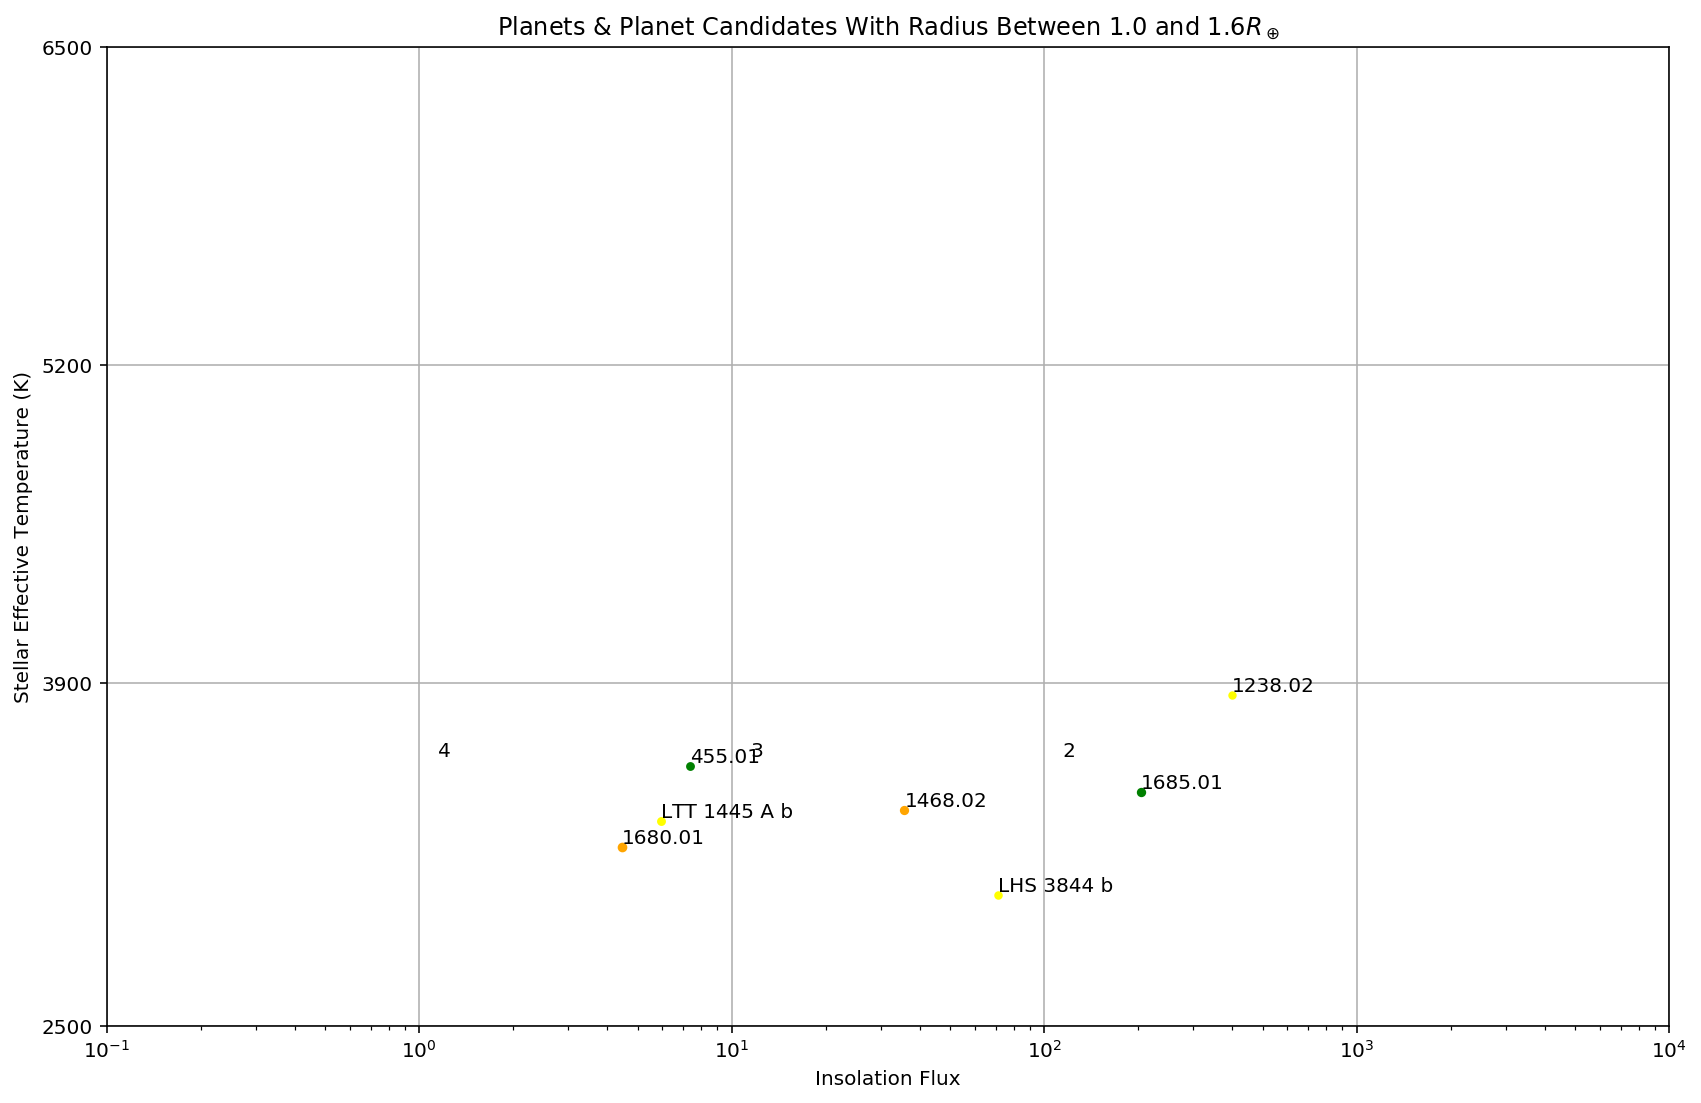

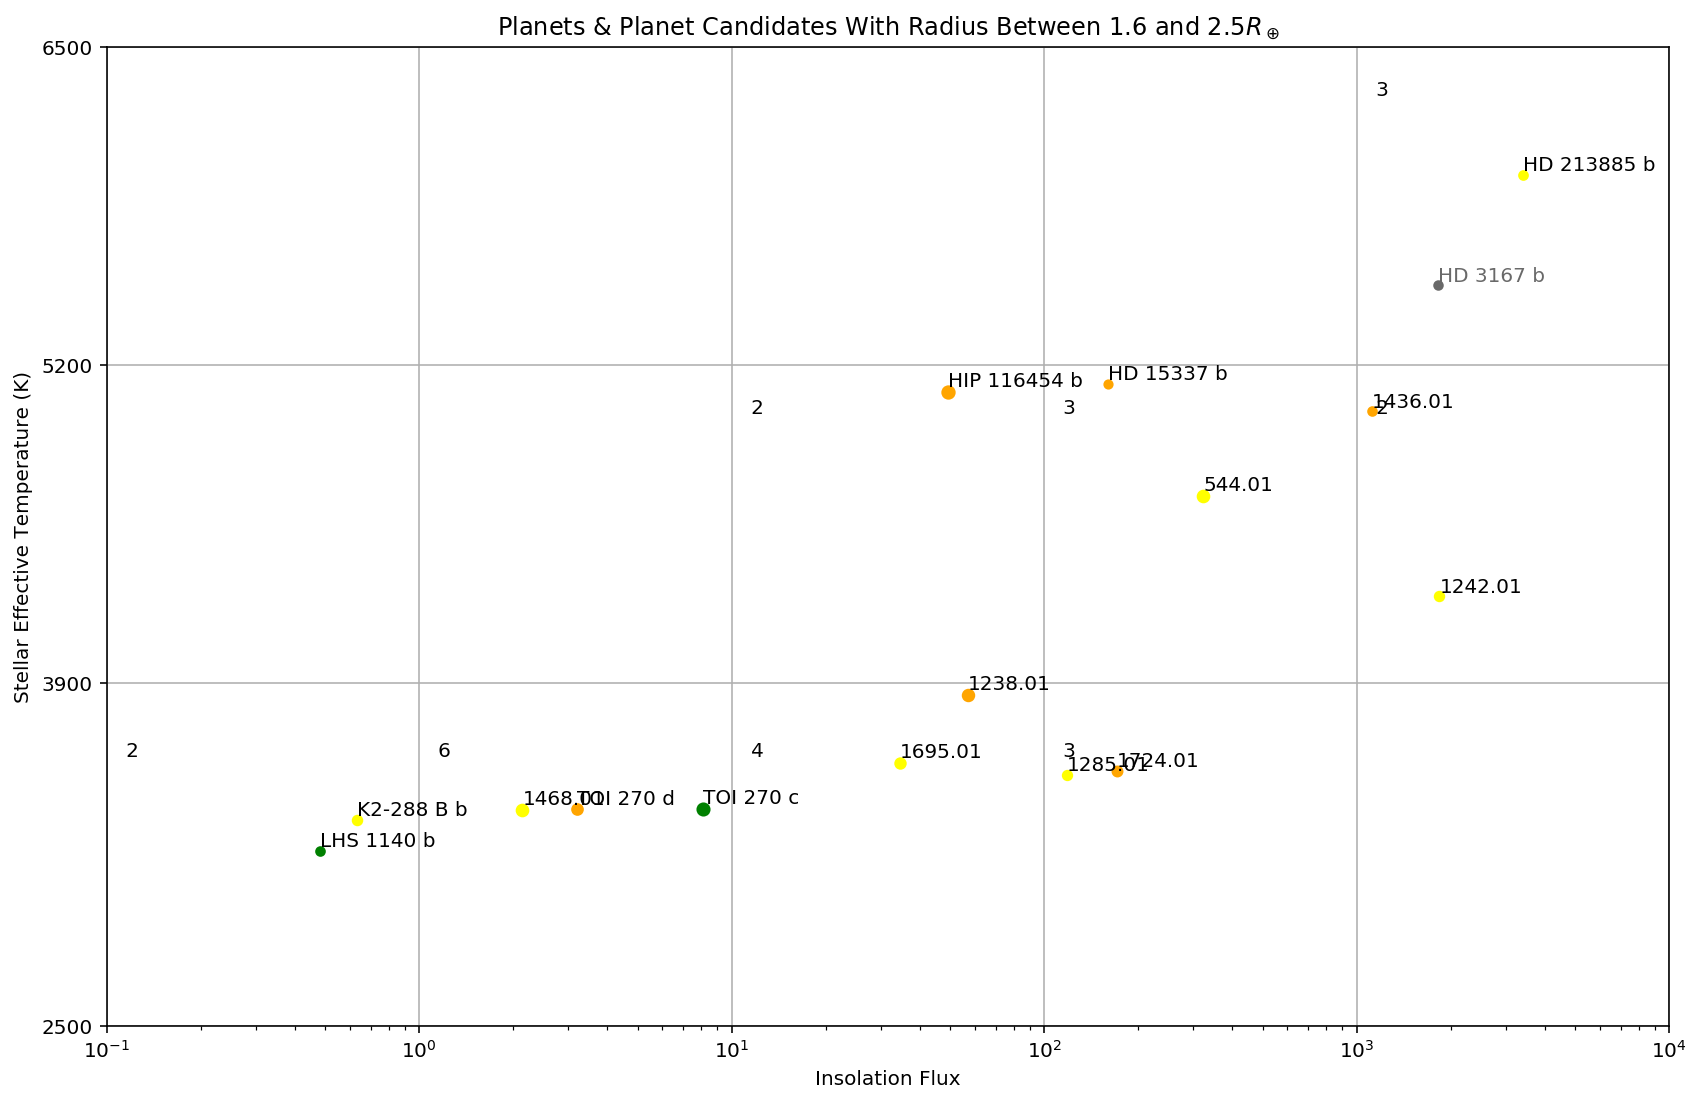

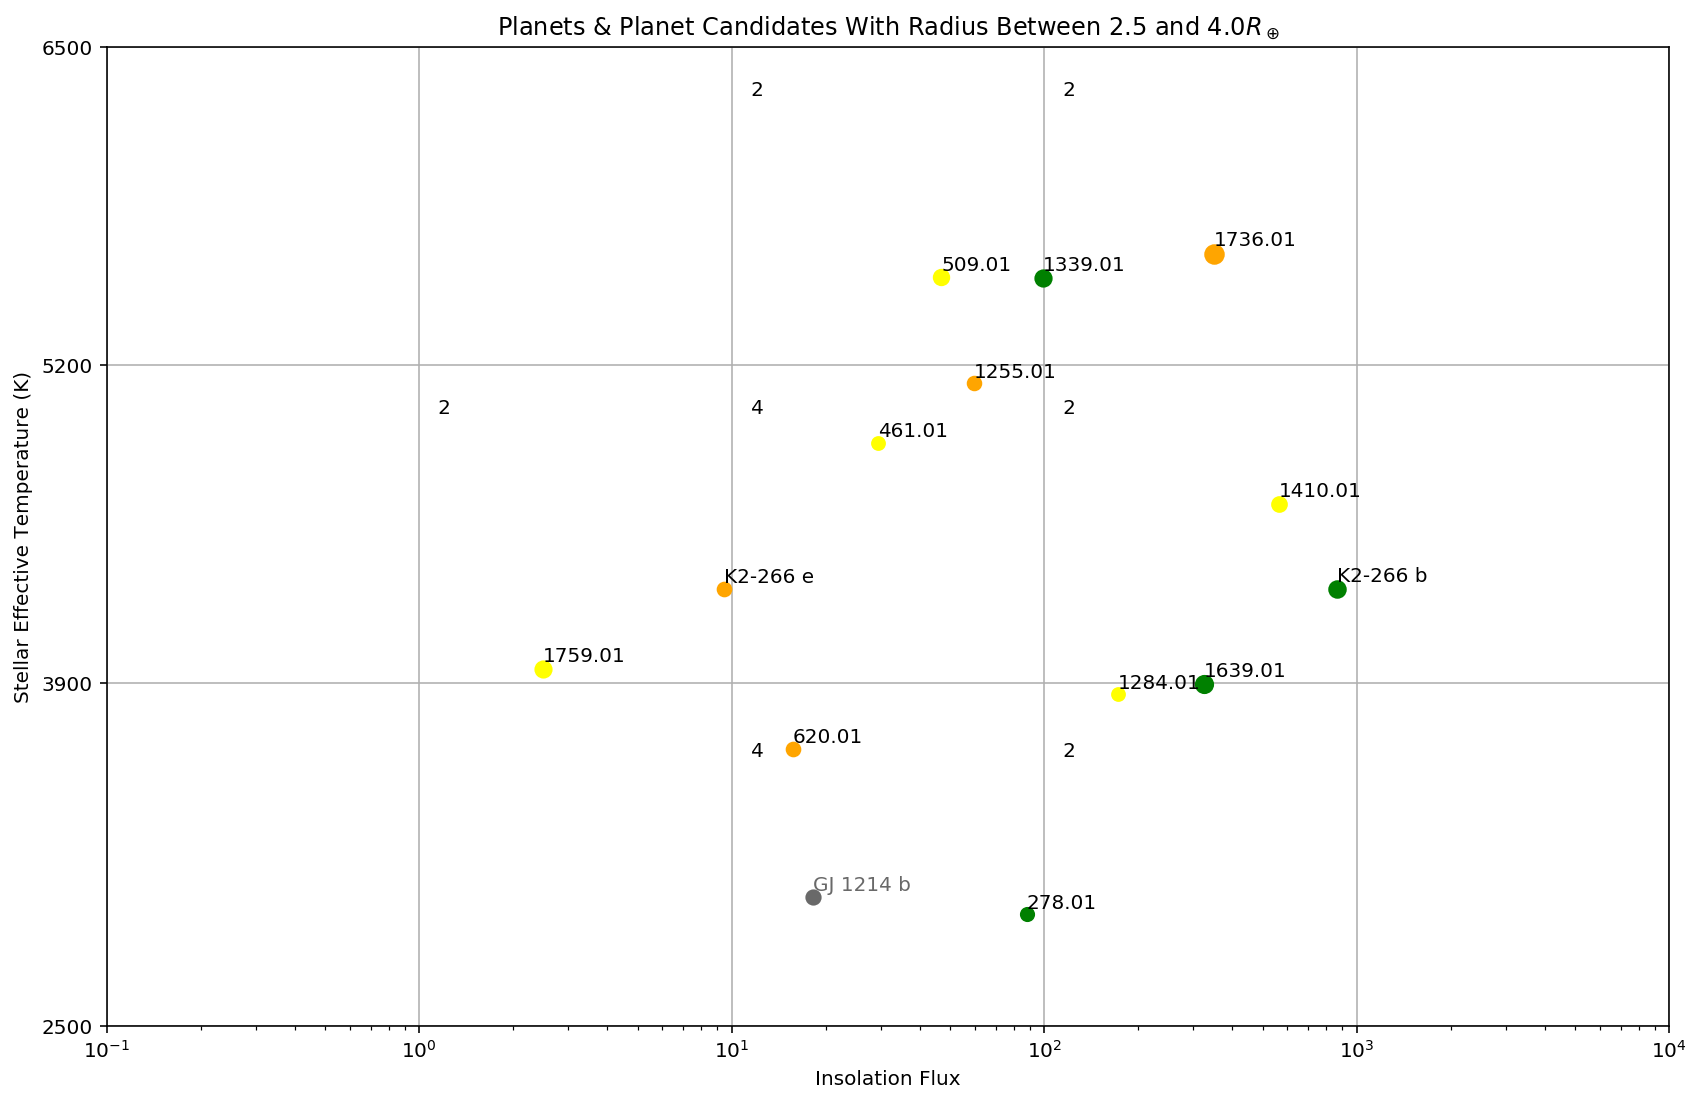

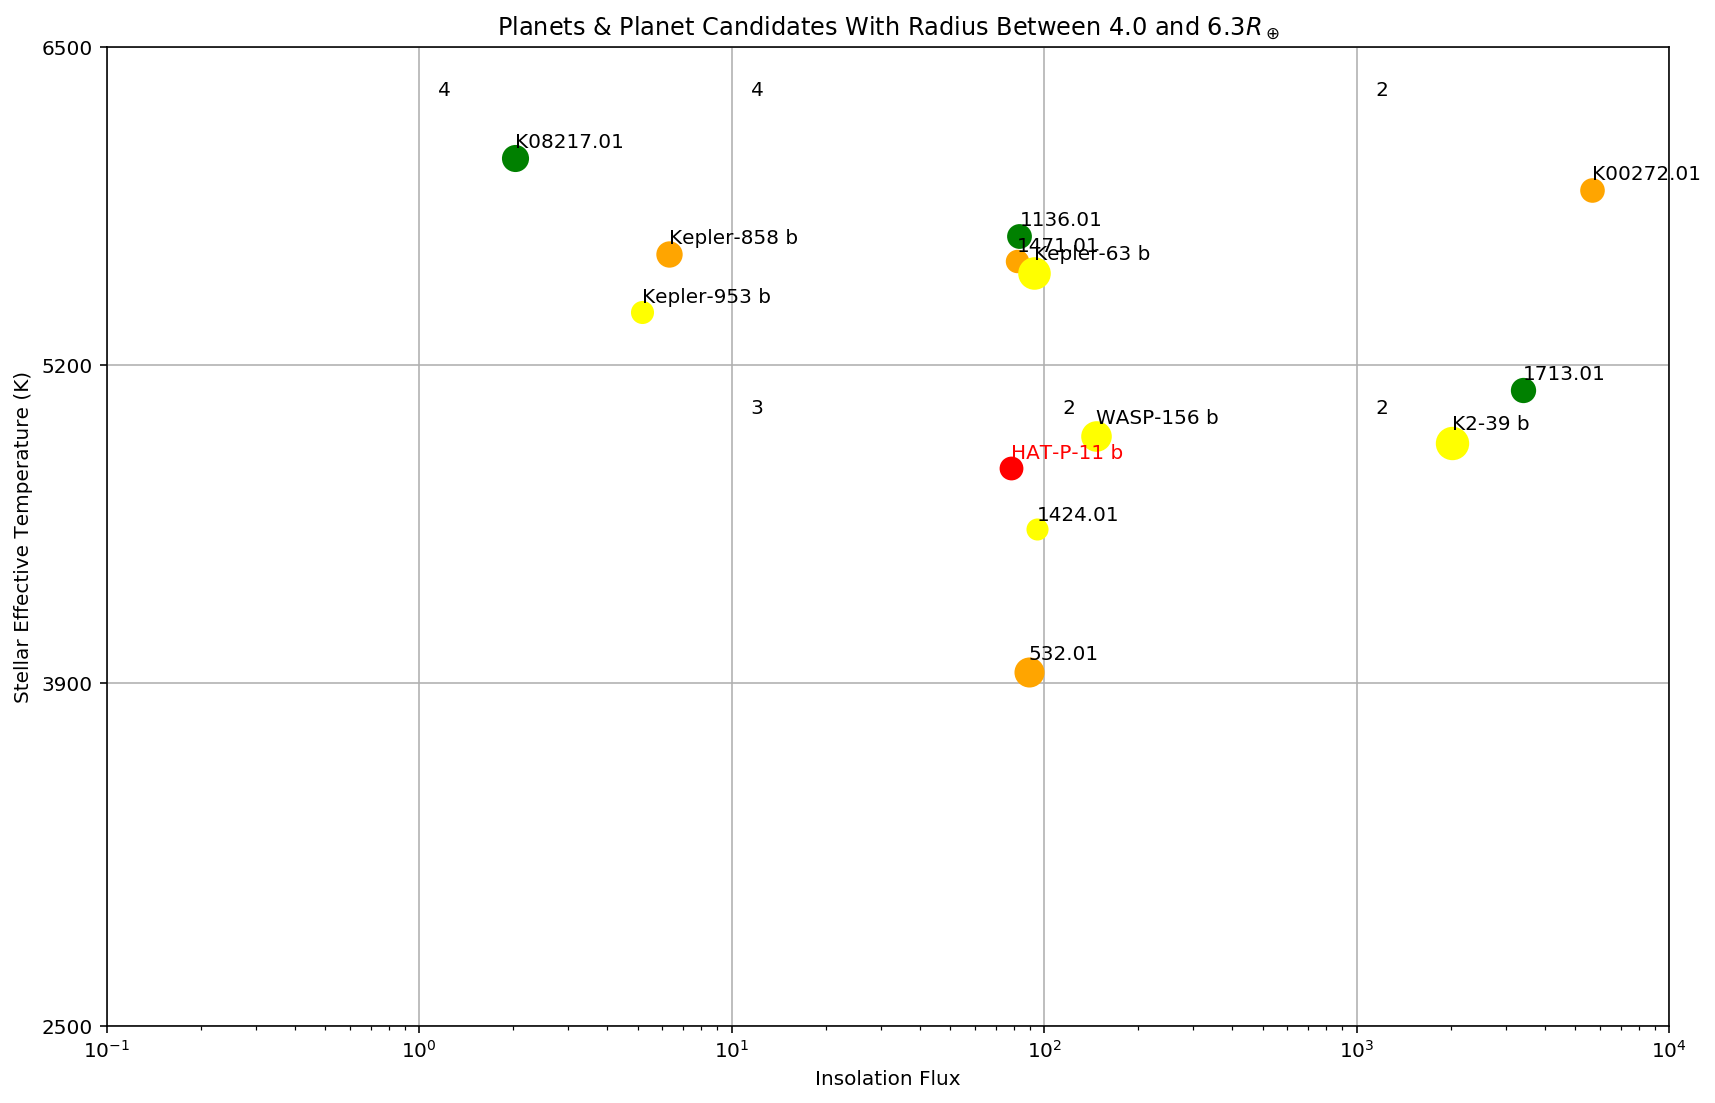

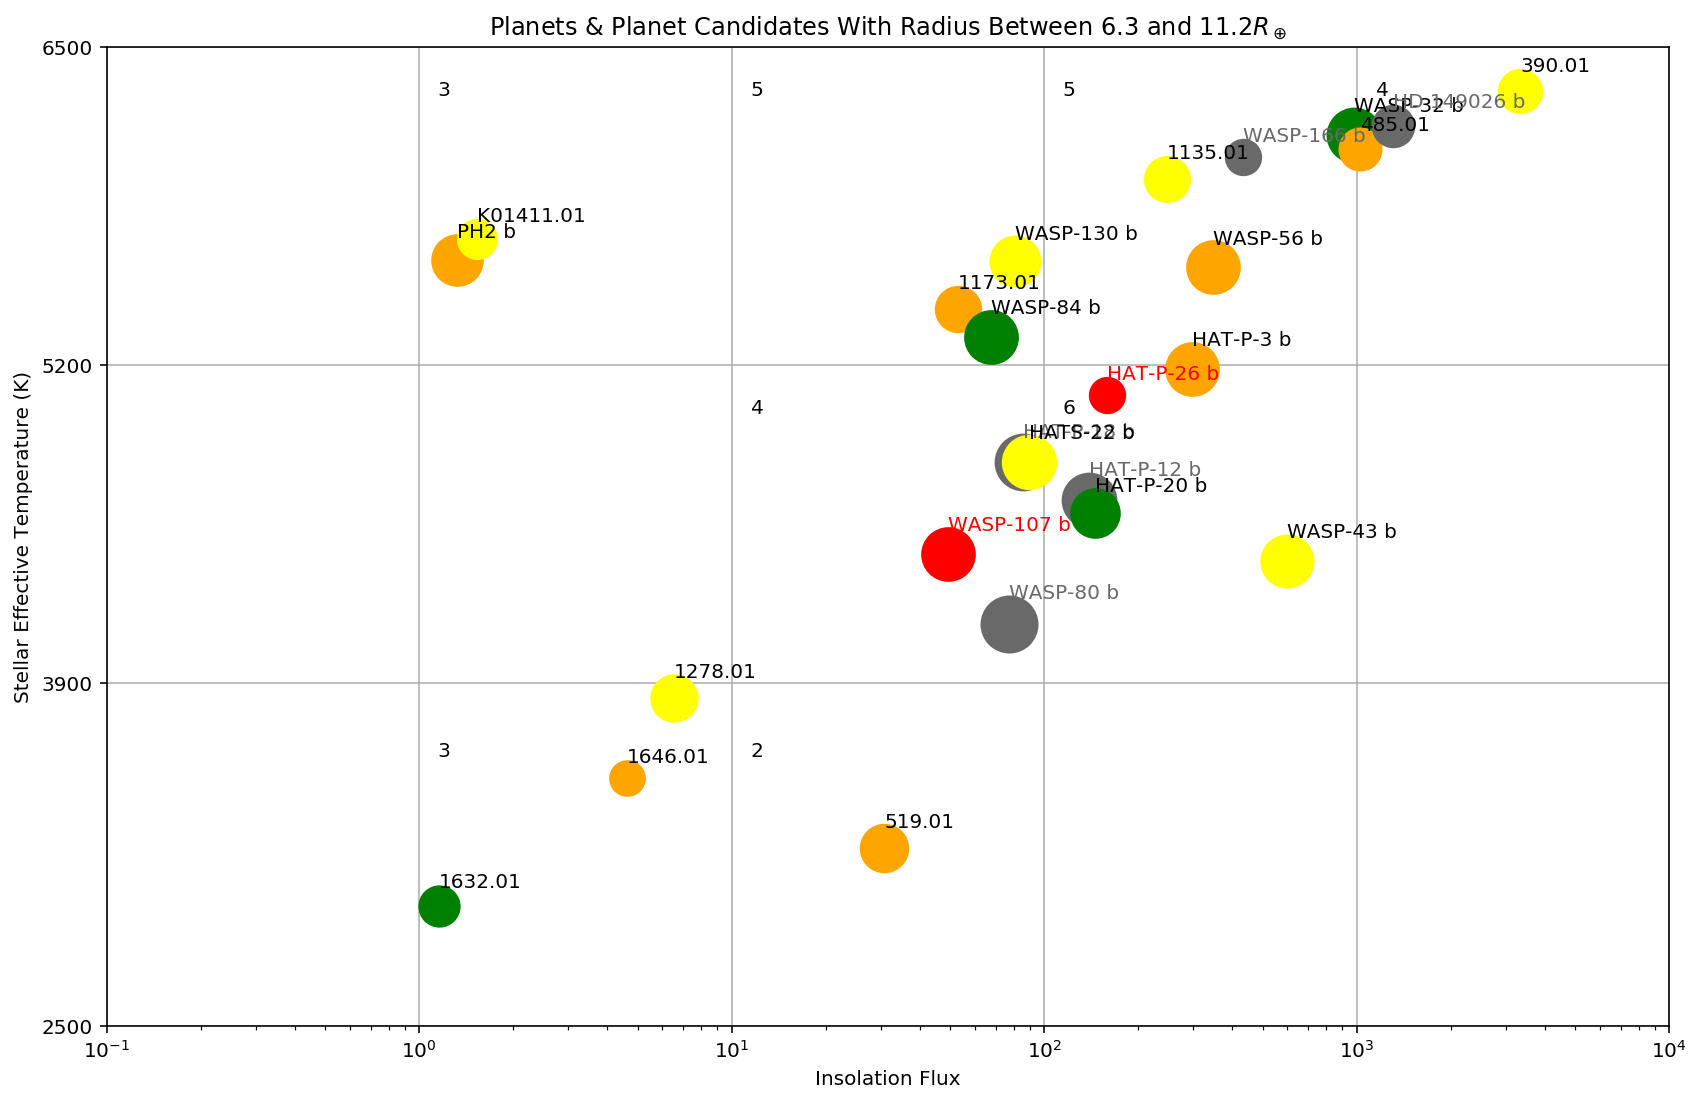

In [15]:
# Code in this cell adapted from Nicholas
for i in np.arange(1,6):
    bin_plotter(compare_diff_df.rename(columns={'X_priority':'priority'}),bins,i)

## Let's plot the X metric and histograms of the priorities as functions of different variables 

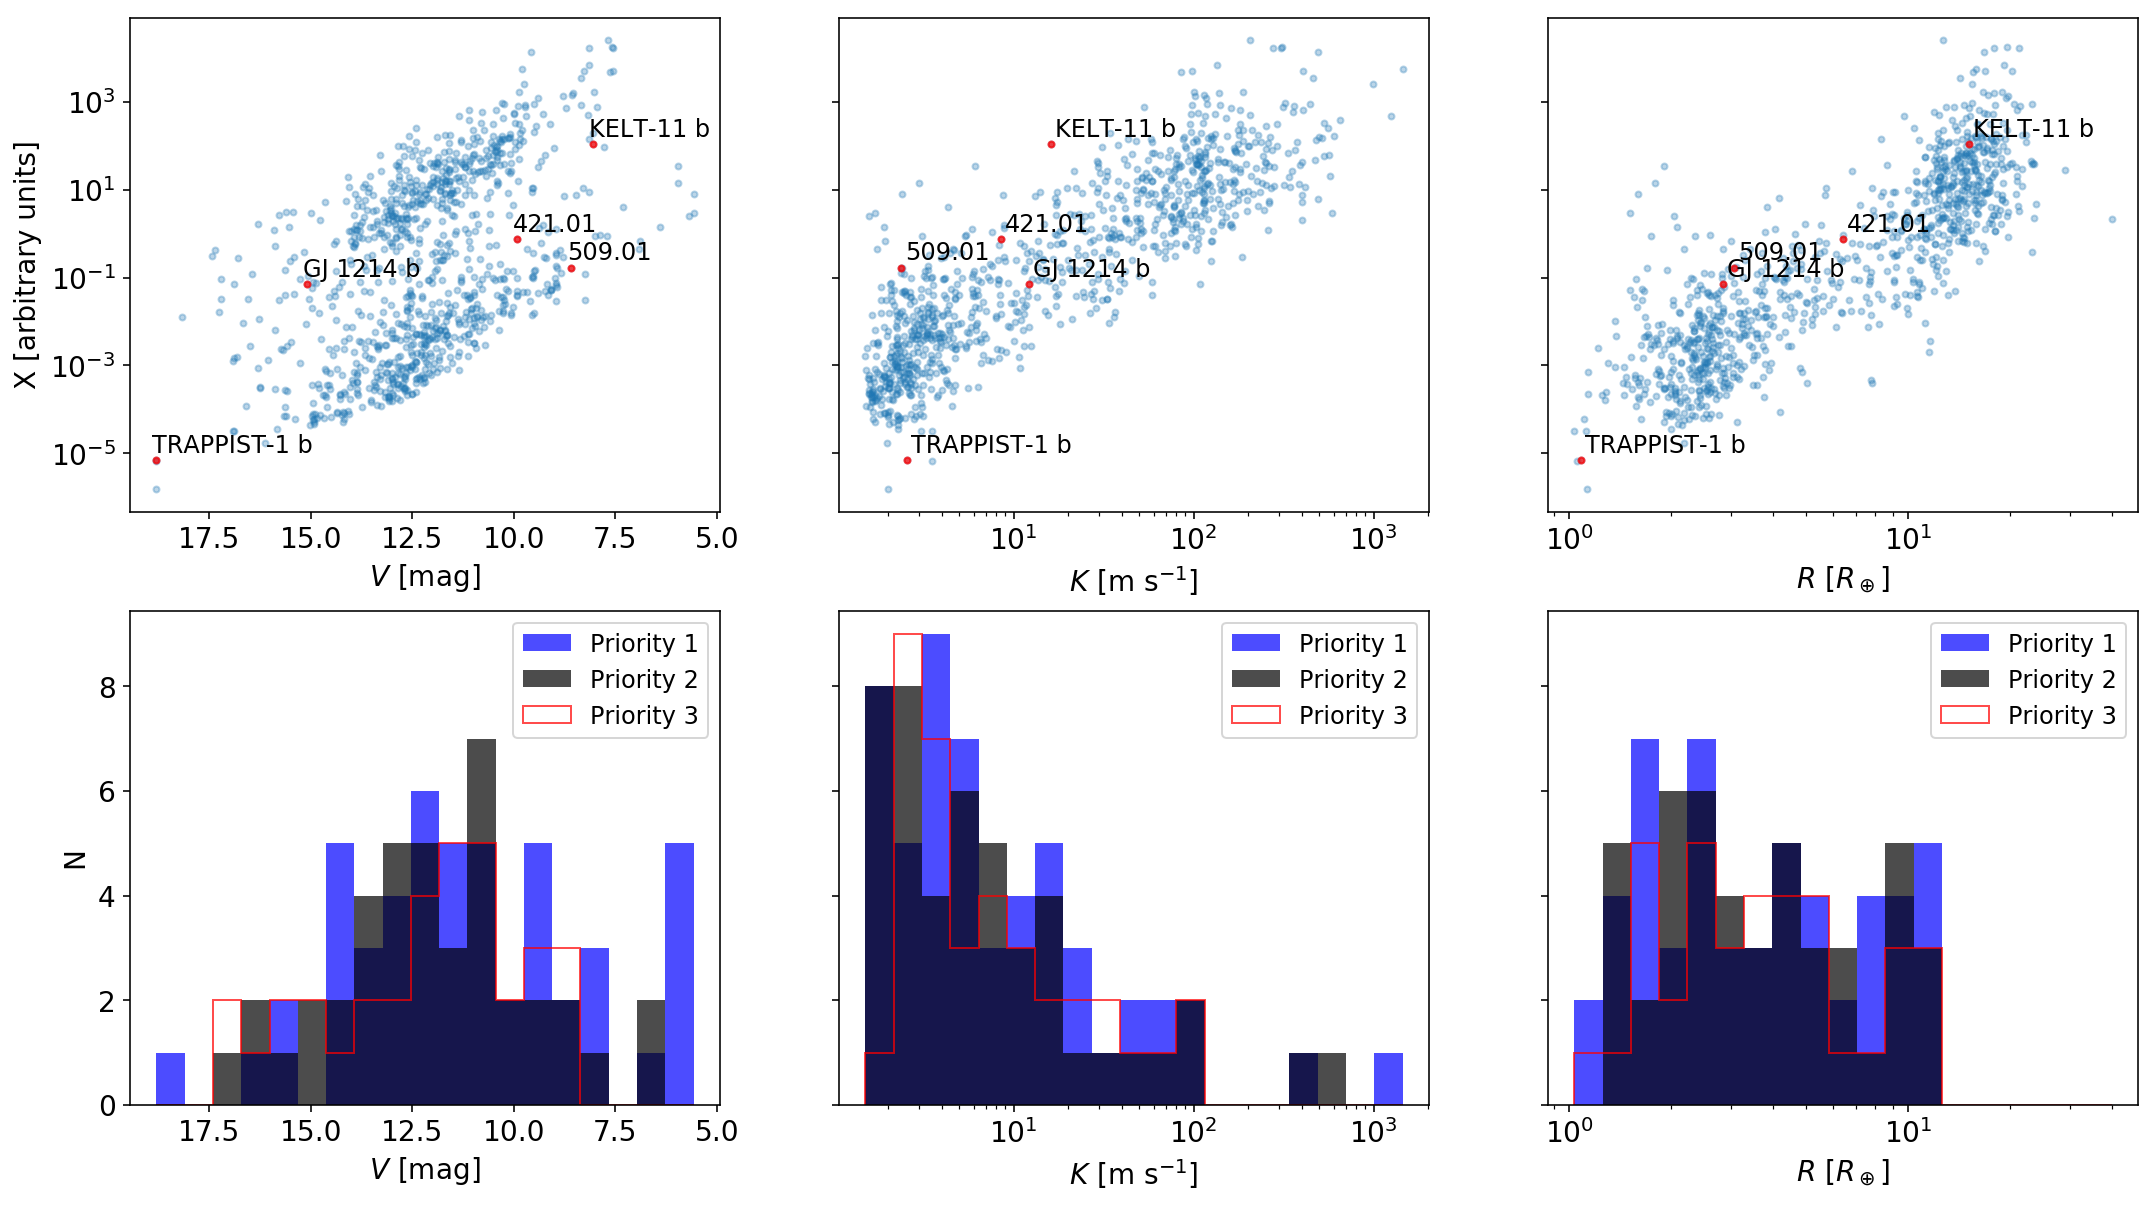

In [16]:
benchmark_planets = ['GJ 1214 b', 'KELT-11 b', 'TRAPPIST-1 b', 509.01, 421.01] 
# Additional benchmark systems may include... [561.01, 1136.01, 1728.01]

def plot_benchmark_planets(planet_list):
    for planet in planet_list:
        curr_row = df[df['Full TOI ID'] == planet]
        
        if type(planet) != str:
            planet = str(planet)
        
        ax_vmag.plot(curr_row['V mag'].values, curr_row['X'].values, '.', color='red', alpha=0.7)
        ax_vmag.text(curr_row['V mag'].values[0] + 0.1, curr_row['X'].values[0] * 1.5, planet, fontsize=12)
        
        ax_kamp.plot(curr_row['K_amp'].values, curr_row['X'].values, '.', color='red', alpha=0.7)
        ax_kamp.text(curr_row['K_amp'].values[0] * 1.05, curr_row['X'].values[0] * 1.5, planet, fontsize=12)
        
        ax_rad.plot(curr_row['Planet Radius Value'].values, curr_row['X'].values, '.', color='red', alpha=0.7)
        ax_rad.text(curr_row['Planet Radius Value'].values[0] * 1.025, 
                    curr_row['X'].values[0] * 1.5, planet, fontsize=12)
        
fig, axes = plt.subplots(figsize=(18,10), ncols=3, nrows=2, sharey='row', sharex='col')
ax_vmag, ax_kamp, ax_rad, ax_p_vmag, ax_p_kamp, ax_p_rad = axes.flatten()

# Plot as a function of V magnitude
ax_vmag.plot(df['V mag'], df['X'], '.', alpha=0.3)
vmag_low, vmag_high = ax_vmag.get_xlim()
ax_vmag.set_xlim([vmag_high, vmag_low]) # Invert x axis
ax_vmag.set_xlabel('$V$ [mag]', fontsize=14)

# Plot as a function of K-amplitude
ax_kamp.plot(df['K_amp'], df['X'], '.', alpha=0.3)
ax_kamp.set_xlabel('$K$ [m s$^{-1}$]', fontsize=14)

# Plot as a function of radius (though I think this is the same information as K-amplitude)
ax_rad.plot(df['Planet Radius Value'], df['X'], '.', alpha=0.3)
ax_rad.set_xlabel('$R$ [$R_\oplus$]', fontsize=14)

# Mark some notable planets for context
plot_benchmark_planets(benchmark_planets)

# Plot histograms of p1, p2, and p3 targets
hist_axes = [ax_p_vmag, ax_p_kamp, ax_p_rad]
hist_keys = ['V mag', 'K_amp', 'Planet Radius Value']
for ax, key in zip(hist_axes, hist_keys):
    bins = None
    if key == 'V mag':
        bins = np.linspace(df[key].min(), df[key].max(), 20)
    else:
        bins = np.logspace(np.log10(df[key].min()), np.log10(df[key].max()), 20)
    colors = ['blue', 'black', 'red']
    for i in range(1, 4):
        histtype = None
        if i == 1 or i == 2:
            histtype='stepfilled'
        elif i == 3:
            histtype='step'
        ax.hist(compare_df[compare_df['X_priority'] == i][key].dropna().values, 
                bins=bins, histtype=histtype, alpha=0.7, color=colors[i-1], label='Priority {}'.format(i))
    ax.legend(fancybox=True, fontsize=12)
ax_p_vmag.set_ylabel('N', fontsize=14)
ax_p_vmag.set_xlabel('$V$ [mag]', fontsize=14)
ax_p_kamp.set_xlabel('$K$ [m s$^{-1}$]', fontsize=14)
ax_p_rad.set_xlabel('$R$ [$R_\oplus$]', fontsize=14)

# Log scales needed to see structure
ax_vmag.set_yscale('log')
ax_kamp.set_xscale('log')
ax_rad.set_xscale('log')

# Plot housekeeping
ax_vmag.set_ylabel(r'X [arbitrary units]', fontsize=14)

for ax in axes.flatten():
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
    ax.tick_params(axis='both', labelsize=14)

plt.show()

**Note**: There seem to be some priority 1 targets with really faint V magnitudes... One of these is TRAPPIST-1 g, which is the only member of bin (1,1,1), making it priority 1 by default. This is the case for several bins that are underpopulated.

In general, it seems like the priority rankings of our most notable targets either stay the same or improve (save for TOI-509.01, which falls to priority 2 in its bin, but that's because it swaps places with TOI-1339.01).

In [17]:
notable_tois = [421.01, 469.01, 509.01, 561.01, 1136.01, 1339.01, 1728.01]
compare_df.loc[compare_df['Full TOI ID'].isin(notable_tois)] # TOIs will be displayed by bin

Full TOI ID  Planet Radius Value  \
radius_bin insol_bin st_Teff_bin                                    
3          3         3               1339.01             3.247601   
                     3                469.01             3.685246   
                     3                509.01             3.073257   
                     3                561.01             3.772776   
4          3         2               1728.01             4.699432   
                     3               1136.01             4.559920   
5          3         3                421.01             6.445067   

                                  Orbital Period Value  \
radius_bin insol_bin st_Teff_bin                         
3          3         3                        8.880832   
                     3                       13.632935   
                     3                       18.119809   
                     3                       10.781327   
4          3         2                        3.491567   
                     3                       12.518414   
5          3         3                       16.068919   

                                  Effective Temperature Value  \
radius_bin insol_bin st_Teff_bin                                
3          3         3                                5555.70   
                     3                                6114.00   
                     3                                5560.26   
                     3                                5391.00   
4          3         2                                3907.00   
                     3                                5729.00   
5          3         3                                5718.00   

                                  Effective Stellar Flux Value  \
radius_bin insol_bin st_Teff_bin                                 
3          3         3                               99.065848   
                     3                               89.071512   
                     3                               46.819522   
                     3                               66.330454   
4          3         2                               57.019625   
                     3                               83.344567   
5          3         3                               74.824872   

                                  Planet Equilibrium Temperature (K) Value  \
radius_bin insol_bin st_Teff_bin                                             
3          3         3                                          804.638372   
                     3                                          783.527882   
                     3                                          667.154613   
                     3                                          727.860233   
4          3         2                                          700.851229   
                     3                                          770.617866   
5          3         3                                          750.120865   

                                   V mag      K_amp         TSM     t_HIRES  \
radius_bin insol_bin st_Teff_bin                                              
3          3         3             8.970   3.394956  131.538519  408.095981   
                     3             9.490   3.216821  104.239872  733.798527   
                     3             8.580   2.374869   97.542021  582.306074   
                     3            10.252   4.159028   87.143100  885.619291   
4          3         2            12.390  11.653890  134.915225  808.144258   
                     3             9.534   5.129485  107.115012  300.526808   
5          3         3             9.931   8.544846  117.365892  156.106956   

                                         X  TSM_Vmag_priority  X_priority  
radius_bin insol_bin st_Teff_bin                                           
3          3         3            0.322323                2.0         1.0  
                     3            0.142055                3.0   

## There are a few more things to do...
- What is a good way to make this a global metric? If you were to sort the entire target list just by this $X$ ratio, then clearly the planets that are the biggest and around the brightest stars would be ranked at the top, but they're not always that interesting.
    - Maybe, once the priorities are assigned within bins, we can do some sort of global metric on the targets that are ranked? This would help mitigate the over-representation of large planets around bright stars, since each bin only gets a maximum of three ranked targets.
- How to properly sample over parameter space so that we're getting an even spread of targets?
- What is a good method for picking the number of exposure meter counts per target, e.g. is it a function of V mag and K_amp? If we had a function to do this, then we would be able to pick the exposure meter counts for targets more precisely, whereas in this notebook we just used 250k for everything.
    - Though, I did try using the different exposure count numbers (i.e. 60k, 125k) and the rankings didn't change much. - Joey 03/23/20
- Is there a way we can calculate the velocity precision expected from the exposure meter counts instead of just using the velocity precision figure here: https://caltech-ipac.github.io/hiresprv/performance.html ???
- As a follow-up to above question, for targets that already have observations on Jump, we should measure $\sigma$ directly from their RVs.
- Also, should we ourselves adjust t_HIRES if the target already has some observations? Or should we leave it as the total time, and let Ashley's code handle that? Does her code handle that?

Joey, 03/22/20